# Import Libraries

In [129]:
import tensorflow as tf
from tensorflow.python.keras import layers
import os
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import cv2
from PIL import Image



## Load the data

In [130]:
shape=(64,64)

In [131]:
def load_images(folder, image_size=(64, 64)):
    images = []
    for filename in tqdm(os.listdir(folder)):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
            img_path = os.path.join(folder, filename)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, image_size)
                img = img.astype(np.float32) / 255.0
                img = (img - 0.5) * 2  # Normalize for tanh activation
                images.append(img)
            else:
                print(f"Warning: Could not load image {img_path}")
        else:
            print(f"Skipping non-image file: {filename}")
    return np.array(images)


In [132]:
real_images = load_images(r'Data\Real Data',image_size=shape)

100%|██████████| 1381/1381 [00:35<00:00, 38.98it/s]


In [133]:
real_images.shape

(1381, 64, 64, 3)

# Data Preprocessing

## Split the data

In [134]:
from sklearn.model_selection import train_test_split
print(f"Loaded {real_images.shape[0]} images with shape {real_images.shape[1:]}")
real_images, real_images_test = train_test_split(real_images, test_size=0.2, random_state=42)
print(f"Training set: {real_images.shape}, Test set: {real_images_test.shape}")

Loaded 1381 images with shape (64, 64, 3)
Training set: (1104, 64, 64, 3), Test set: (277, 64, 64, 3)


In [135]:
def analyze_images(folder_path):
    sizes = []
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
            img_path = os.path.join(folder_path, filename)
            with Image.open(img_path) as img:
                sizes.append(img.size)
    return sizes

In [136]:
def calculate_average_size(sizes):
    if sizes:
        total_width = sum(width for width, height in sizes)
        total_height = sum(height for width, height in sizes)
        count = len(sizes)
        average_size = (total_width // count, total_height // count)
        print(f"Average image size: {average_size}")
        return average_size
    print("No image sizes to analyze.")
    return None

In [137]:
def plot_image_sizes(sizes):
    widths, heights = zip(*sizes)
    plt.figure(figsize=(12, 6))
    plt.hist(widths, bins=30, alpha=0.5, color='b', label='Width')
    plt.hist(heights, bins=30, alpha=0.5, color='r', label='Height')
    plt.xlabel('Size (pixels)')
    plt.ylabel('Frequency')
    plt.title('Image Width and Height Distribution')
    plt.legend(loc='upper right')
    plt.show()

Average image size: (1049, 954)


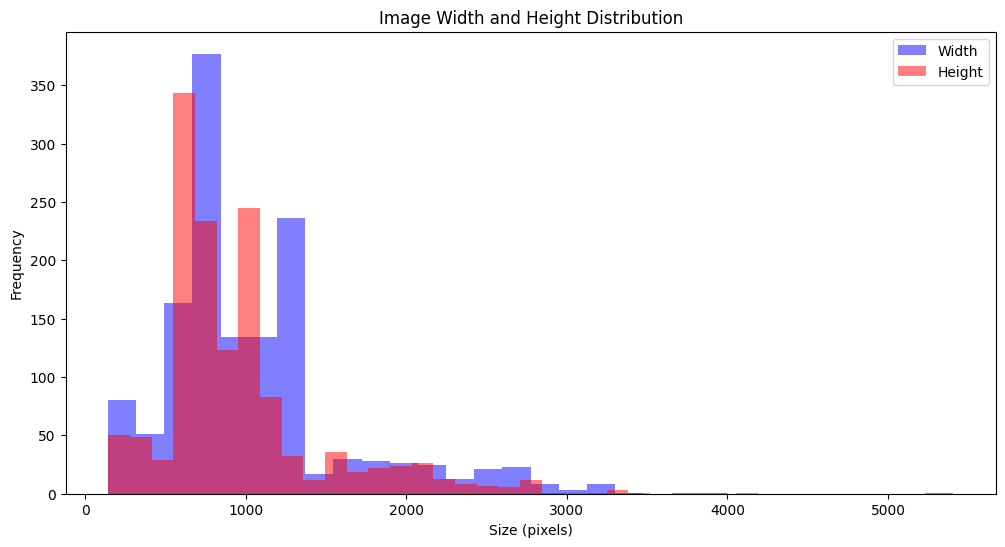

In [138]:
folder_path = r'Data\Real Data'
image_sizes = analyze_images(folder_path)
calculate_average_size(image_sizes)
plot_image_sizes(image_sizes)

# Data Visualization

In [139]:
def plot_image_histogram(image, color_mode='grayscale', bins=256):
    if image is not None:
        plt.figure(figsize=(10, 5))
        if color_mode == 'grayscale':
            plt.hist(image.ravel(), bins=bins, color='black', alpha=0.7)
            plt.title("Grayscale Image Histogram")
            plt.xlabel("Pixel Intensity")
            plt.ylabel("Frequency")
        elif color_mode == 'rgb':
            colors = ('b', 'g', 'r')
            for i, color in enumerate(colors):
                plt.hist(image[:, :, i].ravel(), bins=bins, color=color, alpha=0.5, label=f'{color.upper()} channel')
            plt.title("RGB Image Histogram")
            plt.xlabel("Pixel Intensity")
            plt.ylabel("Frequency")
            plt.legend(loc='upper right')
        plt.show()

In [140]:
def plot_sample_images(images, examples=5, dim=(1, 5), figsize=(12, 2)):
    plt.figure(figsize=figsize)
    for i in range(examples):
        plt.subplot(dim[0], dim[1], i + 1)
        plt.imshow((images[i] + 1) / 2)  # Rescale back to [0, 1] for display
        plt.axis('off')
    plt.tight_layout()
    plt.show()

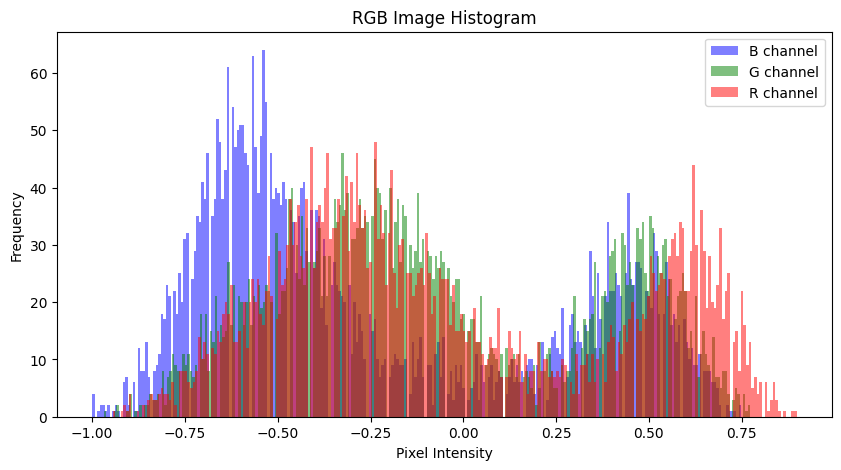

In [141]:
# Example usage:
plot_image_histogram(real_images[0], color_mode='rgb')

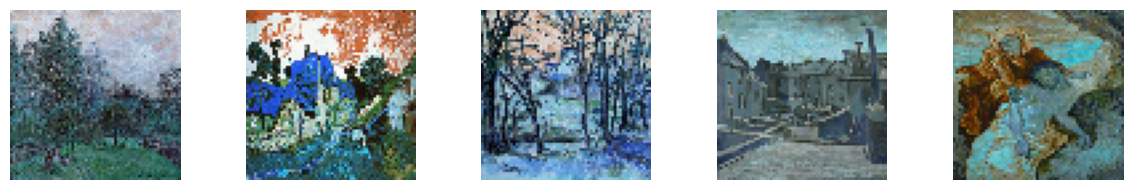

In [142]:
plot_sample_images(real_images)


# Define the Generator

In [143]:
def residual_block(input_tensor, filters, kernel_size=3, strides=1):
    x = layers.Conv2D(filters, kernel_size=kernel_size, strides=strides, padding='same')(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    x = layers.Conv2D(filters, kernel_size=kernel_size, strides=strides, padding='same')(x)
    x = layers.BatchNormalization()(x)
    
    # Add the input to the output (skip connection)
    x = layers.Add()([x, input_tensor])
    x = layers.ReLU()(x)
    return x

In [144]:
# 2. Define the Generator
def build_dcgan_generator():
    noise = layers.Input(shape=(100,))
    x = layers.Dense(512 * 4 * 4)(noise)
    x = layers.Reshape((4, 4, 512))(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Add residual blocks here
    x = residual_block(x, filters=512)
    x = residual_block(x, filters=512)

    x = layers.Conv2DTranspose(256, kernel_size=5, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # More residual blocks after upsampling
    x = residual_block(x, filters=256)

    x = layers.Conv2DTranspose(128, kernel_size=5, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Output layer: ensure output size is 64x64
    output_image = layers.Conv2DTranspose(3, kernel_size=5, strides=2, padding='same', activation='tanh')(x)

    model = tf.keras.Model(inputs=noise, outputs=output_image)
    return model


# Define the Discriminator

In [145]:
# 3. Define the Discriminator
def build_dcgan_discriminator():
    model = tf.keras.Sequential()
    
    model.add(layers.Conv2D(64, kernel_size=5, strides=2, padding='same', input_shape=(64, 64, 3)))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))  # Dropout for regularization

    model.add(layers.Conv2D(128, kernel_size=5, strides=2, padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, kernel_size=5, strides=2, padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))

    return model


# Build and Compile the GAN

In [146]:
# 4. Build and Compile the GAN
def build_gan(generator, discriminator):
    discriminator.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5),
                          loss='binary_crossentropy', metrics=['accuracy'])
    
    discriminator.trainable = False  # Discriminator is frozen during GAN training
    
    noise = layers.Input(shape=(100,))
    generated_image = generator(noise)
    
    # Pass the generated image through the discriminator
    validity = discriminator(generated_image)
    
    gan = tf.keras.Model(noise, validity)
    gan.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5),
                loss='binary_crossentropy')
    
    return gan


# Training Process

In [147]:
# 6. Plot Generated Images
def plot_generated_images(generator, epoch, examples=10, dim=(1, 10), figsize=(10, 1)):
    noise = np.random.normal(0, 1, (examples, 100))
    generated_images = generator.predict(noise)
    generated_images = 0.5 * generated_images + 0.5

    plt.figure(figsize=figsize)
    for i in range(examples):
        plt.subplot(dim[0], dim[1], i + 1)
        plt.imshow(generated_images[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()


In [148]:
# 7. Save Generated Images
def save_generated_image(epoch, generator):
    noise = np.random.normal(0, 1, (1, 100))
    generated_image = generator.predict(noise)[0]
    generated_image = 0.5 * generated_image + 0.5
    
    if not os.path.exists('generated_images'):
        os.makedirs('generated_images')
    
    plt.imshow(generated_image)
    plt.axis('off')
    plt.savefig(f"generated_images/epoch_{epoch}.png")
    plt.close()


In [149]:
def load_latest_checkpoint(generator_builder, discriminator_builder, gan_builder, checkpoint_dir='checkpoints'):
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)
        return None, None, None, 0  # No checkpoints, start from epoch 0

    checkpoint_files = os.listdir(checkpoint_dir)
    if not checkpoint_files:
        return None, None, None, 0

    generator_files = [f for f in checkpoint_files if f.startswith('generator_epoch_') and f.endswith('.h5')]
    discriminator_files = [f for f in checkpoint_files if f.startswith('discriminator_epoch_') and f.endswith('.h5')]
    gan_files = [f for f in checkpoint_files if f.startswith('gan_epoch_') and f.endswith('.h5')]

    if not generator_files or not discriminator_files or not gan_files:
        return None, None, None, 0

    epochs = [int(f.split('_epoch_')[1].split('.h5')[0]) for f in generator_files]
    latest_epoch = max(epochs)

    generator = generator_builder()
    discriminator = discriminator_builder()
    discriminator.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5),
                          loss='binary_crossentropy', metrics=['accuracy'])
    gan = gan_builder(generator, discriminator)

    generator.load_weights(os.path.join(checkpoint_dir, f'generator_epoch_{latest_epoch}.h5'))
    discriminator.load_weights(os.path.join(checkpoint_dir, f'discriminator_epoch_{latest_epoch}.h5'))
    gan.load_weights(os.path.join(checkpoint_dir, f'gan_epoch_{latest_epoch}.h5'))

    print(f"Loaded models from epoch {latest_epoch}")

    return generator, discriminator, gan, latest_epoch

In [150]:
def train_gan(generator, discriminator, gan, real_images, epochs=10000, batch_size=64, discriminator_steps=2, start_epoch=0):
    half_batch = int(batch_size / 2)

    for epoch in range(start_epoch, epochs):
        for _ in range(discriminator_steps):
            # Train the discriminator on real images
            idx_real = np.random.randint(0, real_images.shape[0], half_batch)
            real_batch = real_images[idx_real]

            # Generate new fake images
            noise = np.random.normal(0, 1, (half_batch, 100))
            generated_images = generator.predict(noise)

            # Train discriminator on real images (label smoothing applied)
            real_labels = np.ones((half_batch, 1)) * 0.9  # Smoothing real labels to 0.9
            d_loss_real = discriminator.train_on_batch(real_batch, real_labels)

            # Train discriminator on generated images
            fake_labels = np.zeros((half_batch, 1))  # Label for fake data is 0
            d_loss_generated = discriminator.train_on_batch(generated_images, fake_labels)

            # Calculate the average loss for the discriminator
            d_loss = (d_loss_real[0] + d_loss_generated[0]) / 2

        # Train the generator: generate noise and try to fool the discriminator
        noise = np.random.normal(0, 1, (batch_size, 100))
        valid_labels = np.ones((batch_size, 1))  # Generator tries to make discriminator classify generated images as real
        g_loss = gan.train_on_batch(noise, valid_labels)

        # Print progress and save checkpoints
        if epoch % 100 == 0:
            print(f"{epoch}/{epochs}, D Loss: {d_loss}, G Loss: {g_loss}")
            save_generated_image(epoch, generator)
            plot_generated_images(generator, epoch)

        # Save model checkpoints every 5000 epochs
        if epoch % 5000 == 0 and epoch != 0:
            if not os.path.exists('checkpoints'):
                os.makedirs('checkpoints')
            generator.save_weights(f"checkpoints/generator_epoch_{epoch}.h5")
            discriminator.save_weights(f"checkpoints/discriminator_epoch_{epoch}.h5")
            gan.save_weights(f"checkpoints/gan_epoch_{epoch}.h5")
            print(f"Saved checkpoints at epoch {epoch}")


# Run the Training

In [152]:
generator, discriminator, gan, start_epoch = load_latest_checkpoint(build_dcgan_generator, build_dcgan_discriminator, build_gan)
if generator is None:
    generator = build_dcgan_generator()
    discriminator = build_dcgan_discriminator()
    gan = build_gan(generator, discriminator)

train_gan(generator, discriminator, gan, real_images, epochs=5100, batch_size=64, start_epoch=start_epoch)

ModuleNotFoundError: No module named 'tensorflow.python.keras.engine.base_layer_v1'

# Evalualte the models

In [61]:
# 8. Evaluation Function
def evaluate_models(generator, discriminator, real_images, batch_size=64, examples=10):
    # Select a batch of real images
    idx_real = np.random.randint(0, real_images.shape[0], batch_size)
    real_batch = real_images[idx_real]
    real_labels = np.ones((batch_size, 1))
    
    # Evaluate discriminator on real images
    d_loss_real = discriminator.evaluate(real_batch, real_labels, verbose=0)
    
    # Generate a batch of new fake images using the generator
    noise = np.random.normal(0, 1, (batch_size, 100))
    generated_images = generator.predict(noise)
    fake_labels = np.zeros((batch_size, 1))
    
    # Evaluate discriminator on generated images
    d_loss_generated = discriminator.evaluate(generated_images, fake_labels, verbose=0)
    
    # Calculate the overall discriminator loss
    d_loss = (d_loss_real[0] + d_loss_generated[0]) / 2
    d_accuracy = (d_loss_real[1] + d_loss_generated[1]) / 2
    
    # Evaluate generator performance (generator's loss is based on fooling the discriminator)
    valid_labels = np.ones((batch_size, 1))
    g_loss = gan.evaluate(noise, valid_labels, verbose=0)
    
    print(f"Discriminator Loss on Real: {d_loss_real[0]}, Generated: {d_loss_generated[0]}")
    print(f"Discriminator Accuracy: {d_accuracy * 100:.2f}%")
    print(f"Generator Loss: {g_loss}")
    
    # Visualize a few generated images
    print("Generated Images:")
    plot_generated_images(generator, epoch='Evaluation', examples=examples, dim=(1, examples), figsize=(10, 1))


2/2 [==============================] - 0s 25ms/step
Discriminator Loss on Real: 0.31281065940856934, Fake: 0.20278942584991455, Generated: 0.807188868522644
Discriminator Accuracy: 59.90%
Generator Loss: 0.5911768674850464
Generated Images:
1/1 [==============================] - 0s 19ms/step


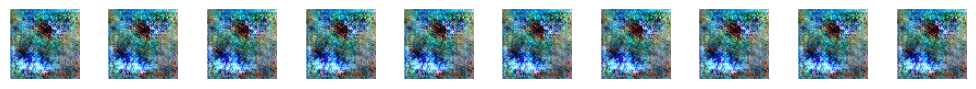

In [62]:
# 9. Run the Evaluation
evaluate_models(generator, discriminator, real_images_test)

# 